In [89]:
import numpy as np
import pandas as pd
import math

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

from sklearn.metrics import accuracy_score


#linear models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, LogisticRegression, RidgeClassifierCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import VotingClassifier,RandomForestClassifier

from sktime.datatypes._panel._convert import from_2d_array_to_nested
from sktime.transformations.panel.rocket import Rocket, MiniRocket
from sktime.classification.feature_based import FreshPRINCE
from sktime.classification.dictionary_based import WEASEL
from sktime.contrib.vector_classifiers._rotation_forest import RotationForest
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor, TSFreshRelevantFeatureExtractor

from mrsqm import MrSQMClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.utils.multiclass import unique_labels
from sklearn.utils.validation import check_is_fitted



import matplotlib.pyplot as plt

In [90]:
#load data
df_dict = pd.read_excel('dataset.xlsx',sheet_name=None)
df = df_dict["Training"]

In [91]:
remove_outliers = True
normalization = False

tmp_df = df.copy()
if remove_outliers:
    tmp_df = tmp_df[tmp_df.iloc[:,1:].mean(axis=1) > 0.8]
    


#shuffle
tmp_df = tmp_df.sample(frac=1,random_state=0).reset_index(drop=True)

X = tmp_df.iloc[:,1:]
Y = tmp_df["Diet"]

if normalization:
    X = X.sub(X.mean(1), axis=0).div(X.std(1), axis=0)

X_ts = from_2d_array_to_nested(X)

In [92]:
Y

0       CLV
1       TMR
2       GRS
3       GRS
4       GRS
       ... 
3239    CLV
3240    TMR
3241    CLV
3242    CLV
3243    TMR
Name: Diet, Length: 3244, dtype: object

In [93]:
class RocketNormalizer(BaseEstimator, TransformerMixin):            
            
    def fit(self, X, y = None):        
        self._mean = X.mean(0)
        self._norm = np.sqrt(np.square(X - self._mean).sum(axis=0)) + 1e-8        
        return self    
    
    def transform(self, X, y = None):                
        return (X - self._mean) / self._norm

class SkMrSQMClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, nsax, nsfa):
        # self.demo_param = demo_param
        self.nsax = nsax
        self.nsfa = nsfa
        

    def fit(self, X, y):
        
        self.clf = MrSQMClassifier(strat = 'RS', nsax = self.nsax, nsfa = self.nsfa, features_per_rep = 500, selection_per_rep = 2000, random_state=0)

        # Check that X and y have correct shape
        # X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ =  unique_labels(y)

        #self.X_ = X
        # self.y_ = y
        # Return the classifier
        self.clf.fit(X,y)
        return self

    def predict(self, X):

        # Check is fit had been called
        check_is_fitted(self)

        # Input validation
        # X = check_array(X)

        # closest = np.argmin(euclidean_distances(X, self.X_), axis=1)
        return self.clf.predict(X)





class IntervalSelector(BaseEstimator, TransformerMixin):
    # initializer 
    def __init__(self, start = 0, end = 10, return_timeseries = True):        
        self.start = start
        self.end = end
        self.return_timeseries = return_timeseries
            
            
    def fit(self, X, y = None):        
        return self    
    
    def transform(self, X, y = None):             
        if self.return_timeseries:
            return from_2d_array_to_nested(X.iloc[:,self.start:self.end])
        else:
            return X.iloc[:,self.start:self.end]
    
class RotationForestClassifier(BaseEstimator, ClassifierMixin):    
        

    def fit(self, X, y):
        
        self.clf = RotationForest(random_state=42)

        # Check that X and y have correct shape
        # X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ =  unique_labels(y)

        #self.X_ = X
        # self.y_ = y
        # Return the classifier
        self.clf.fit(X,y)
        return self

    def predict(self, X):

        # Check is fit had been called
        check_is_fitted(self)

        # Input validation
        # X = check_array(X)

        # closest = np.argmin(euclidean_distances(X, self.X_), axis=1)
        return self.clf.predict(X)
    



In [94]:
def rocket_clf(start = 0, end = 1060, verbose=True):
    return Pipeline(
            [    
            ('interval', IntervalSelector(start = start, end = end, return_timeseries = True)),
            ('rocket', Rocket(random_state=0,normalise=True)),
            ('normalizer', RocketNormalizer()),
            ('model', RidgeClassifierCV(alphas=np.logspace(-3, 3, 10)))           
            ],
            verbose=verbose,
        )

def minirocket_clf(start = 0, end = 1060, verbose=True):
    return Pipeline(
            [
            ('interval', IntervalSelector(start = start, end = end, return_timeseries = True)),
            ('minirocket', MiniRocket(random_state=0)),
            ('normalizer', RocketNormalizer()),
            ('model', RidgeClassifierCV(alphas=np.logspace(-3, 3, 10)))           
            ],
            verbose=verbose,
        )
def freshprince_clf(start = 0, end = 1060, fc_pars = "minimal",verbose=True):
    return Pipeline(
        [
            ('interval', IntervalSelector(start = start, end = end, return_timeseries = True)),
            ('tsfresh', TSFreshFeatureExtractor(default_fc_parameters=fc_pars, show_warnings=False, disable_progressbar=True)),
            ('rotationforest', RotationForestClassifier())
        ],
        verbose=verbose,
    )

def freshprince_fs_clf(start = 0, end = 1060, fc_pars = "efficient",verbose=True):
    return Pipeline(
        [
            ('interval', IntervalSelector(start = start, end = end, return_timeseries = True)),
            ('tsfresh', TSFreshRelevantFeatureExtractor(default_fc_parameters=fc_pars, show_warnings=False, ml_task="classification")),
            ('rotationforest', RotationForestClassifier())
        ],
        verbose=verbose,
    )

def mrsqm_clf(nsax = 0, nsfa = 9, start = 0, end = 1060, verbose=True):
    return Pipeline(
        [
            ('interval', IntervalSelector(start = start, end = end, return_timeseries = True)),
            ('mrsqm', SkMrSQMClassifier(nsax = nsax, nsfa = nsfa)),
            
        ],
        verbose=verbose,
    )

def ridgecv_clf(start = 0, end = 1060, verbose=True):
    return Pipeline(
        [
            ('interval', IntervalSelector(start = start, end = end, return_timeseries = False)),
            ('ridgecv', RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))),
            
        ],
        verbose=verbose,
    )

def lda_clf(start = 0, end = 1060, verbose=True):
    return Pipeline(
        [
            ('interval', IntervalSelector(start = start, end = end, return_timeseries = False)),
            ('lda', LinearDiscriminantAnalysis()),
            
        ],
        verbose=verbose,
    )

def exp_single_clf(clf, X_train, X_test, y_train, y_test):    
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    return accuracy_score(y_test, y_pred)


def exp_multiple_classifiers(clfs, X_train, X_test, y_train, y_test):
    results = dict.fromkeys(clfs.keys(),0)
    
    for c in clfs:
        results[c] = exp_single_clf(clfs[c], X_train, X_test, y_train, y_test)
    
    return results

## Test individual classifiers

### Time Series Classifiers

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

intervals = [(0,172),(205,306),(728,748)]
results = {}

for itv_start, itv_end in intervals:
    print('----------------------')
    print(f'Interval: {itv_start} - {itv_end}')
    print('----------------------')
    #chopper = IntervalSelector(itv_start,itv_end)
    #X_train_itv = chopper.transform(X_train)
    #X_test_itv = chopper.transform(X_test)
    
    clfs = {"Minirocket":minirocket_clf(start=itv_start, end=itv_end,verbose=False),
            "MrSQM 9xsfa": mrsqm_clf(nsax = 0, nsfa = 9,start=itv_start, end=itv_end,verbose=False),
            "FreshPrince-effecient":freshprince_clf(start=itv_start, end=itv_end,fc_pars="efficient",verbose=False),
            #"RidgeCV":ridgecv_clf(start=itv_start, end=itv_end,verbose=False)
           }
    
    for clf in clfs:
        acc = exp_single_clf(clfs[clf], X_train, X_test, y_train, y_test)
        print(f'{clf} : {acc}')
    


# for clf_name, clf in clf_grp:
#     results[clf_name] = exp_single_clf(clf, X_train, X_test, y_train, y_test)

----------------------
Interval: 0 - 172
----------------------
Minirocket : 0.7212614445574771
MrSQM 9xsfa : 0.6836215666327569


Feature Extraction: 100%|█████████████████████| 983/983 [00:45<00:00, 21.38it/s]


FreshPrince-effecient : 0.7029501525940997
RidgeCV : 0.6826042726347915
----------------------
Interval: 205 - 306
----------------------
Minirocket : 0.5228891149542217
MrSQM 9xsfa : 0.4649033570701933


Feature Extraction: 100%|█████████████████████| 983/983 [00:42<00:00, 22.99it/s]


FreshPrince-effecient : 0.5361139369277721
RidgeCV : 0.5157680569684638
----------------------
Interval: 728 - 748
----------------------
Minirocket : 0.3570701932858596
MrSQM 9xsfa : 0.32553407934893186


Feature Extraction: 100%|█████████████████████| 983/983 [00:36<00:00, 27.11it/s]


FreshPrince-effecient : 0.3713123092573754
RidgeCV : 0.3560528992878942


### Tabular classifiers with whole time series


In [74]:
clfs = {           
            "RidgeCV":RidgeClassifierCV(alphas=np.logspace(-3, 3, 10)),
            "LogisticRegression":LogisticRegression(max_iter = 1000),
            "RandomForest":RandomForestClassifier(),
            "LDA":LinearDiscriminantAnalysis()
           }
    
for clf in clfs:
    acc = exp_single_clf(clfs[clf], X_train, X_test, y_train, y_test)
    print(f'{clf} : {acc}')

RidgeCV : 0.7355035605289929


/home/thalng/anaconda3/envs/vistamilk/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression : 0.4486266531027467
RandomForest : 0.5289928789420142
LDA : 0.7385554425228891


### Tabular classifiers with each interval

In [63]:
intervals = [(0,172),(205,306),(728,748)]
results = {}

for itv_start, itv_end in intervals:
    print('----------------------')
    print(f'Interval: {itv_start} - {itv_end}')
    print('----------------------')
    chopper = IntervalSelector(itv_start,itv_end,return_timeseries = False)
    X_train_itv = chopper.transform(X_train)
    X_test_itv = chopper.transform(X_test)
    
    clfs = {           
            "RidgeCV":RidgeClassifierCV(alphas=np.logspace(-3, 3, 10)),
            "LogisticRegression":LogisticRegression(max_iter = 1000),
            "RandomForest":RandomForestClassifier(),
            "LDA":LinearDiscriminantAnalysis()
           }
    
    for clf in clfs:
        acc = exp_single_clf(clfs[clf], X_train_itv, X_test_itv, y_train, y_test)
        print(f'{clf} : {acc}')

----------------------
Interval: 0 - 172
----------------------
RidgeCV : 0.6826042726347915
LogisticRegression : 0.4516785350966429
RandomForest : 0.5381485249237029
LDA : 0.698880976602238
----------------------
Interval: 205 - 306
----------------------
RidgeCV : 0.5157680569684638
LogisticRegression : 0.37639877924720244
RandomForest : 0.41912512716174977
LDA : 0.5483214649033571
----------------------
Interval: 728 - 748
----------------------
RidgeCV : 0.3560528992878942
LogisticRegression : 0.3326551373346897
RandomForest : 0.36927772126144454
LDA : 0.35096642929806715


In [76]:
X_train_no_water = X_train.iloc[:, np.r_[0:172, 205:306, 728:748]]
X_test_no_water = X_test.iloc[:, np.r_[0:172, 205:306, 728:748]]
clfs = {           
            "RidgeCV":RidgeClassifierCV(alphas=np.logspace(-3, 3, 10)),
            "LogisticRegression":LogisticRegression(max_iter = 1000),
            "RandomForest":RandomForestClassifier(),
            "LDA":LinearDiscriminantAnalysis()
           }
    
for clf in clfs:
    acc = exp_single_clf(clfs[clf], X_train_no_water, X_test_no_water, y_train, y_test)
    print(f'{clf} : {acc}')

RidgeCV : 0.71617497456765
LogisticRegression : 0.4526958290946083
RandomForest : 0.5473041709053916
LDA : 0.745676500508647


Accuracy: 0.7609359104781281


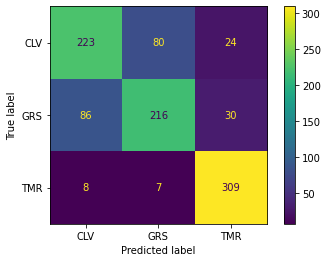

In [73]:
estimators = [ ("mnrk_itv1",minirocket_clf(start=0, end=172,verbose=False)),
           ("mrsqm_itv1",mrsqm_clf(nsax = 0, nsfa = 9,start=0, end=172,verbose=False)),
           ("freshprince_itv1",freshprince_clf(start=0, end=172,fc_pars="efficient",verbose=False)),
           ("RidgeCV_itv1",ridgecv_clf(start=0, end=172,verbose=False)),
             ("LDA_itv1",lda_clf(start=0, end=172,verbose=False)), 
          ]

clf = VotingClassifier(estimators = estimators)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=clf.classes_)
disp.plot()
plt.show()

Accuracy: 0.7293997965412004


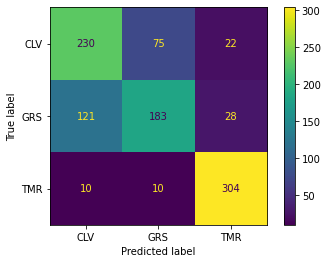

In [87]:
estimators = [ ("mnrk_itv1",minirocket_clf(start=0, end=172,verbose=False)),
           ("mrsqm_itv1",mrsqm_clf(nsax = 0, nsfa = 9,start=0, end=172,verbose=False)),
           #("freshprince_itv1",freshprince_clf(start=0, end=172,fc_pars="efficient",verbose=False)),
           ("RidgeCV_itv1",ridgecv_clf(start=0, end=172,verbose=False)),
             ("LDA_itv1",lda_clf(start=0, end=172,verbose=False)), 
          ]

clf = VotingClassifier(estimators = estimators)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=clf.classes_)
disp.plot()
plt.show()

Accuracy: 0.7497456765005086


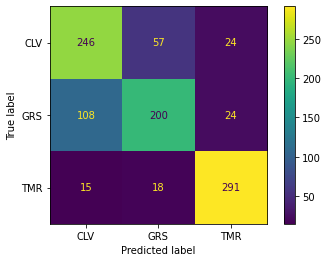

In [85]:
estimators = [ ("mnrk_itv1",minirocket_clf(start=0, end=172,verbose=False)),
           ("mrsqm_itv1",mrsqm_clf(nsax = 0, nsfa = 9,start=0, end=172,verbose=False)),
           ("freshprince_itv1",freshprince_clf(start=0, end=172,fc_pars="efficient",verbose=False)),
           ("RidgeCV_itv1",ridgecv_clf(start=0, end=172,verbose=False)),
             ("LDA_itv1",lda_clf(start=0, end=172,verbose=False)), 
            ("mnrk_itv2",minirocket_clf(start=205, end=306,verbose=False)),
           ("mrsqm_itv2",mrsqm_clf(nsax = 0, nsfa = 9,start=205, end=306,verbose=False)),
           ("freshprince_itv2",freshprince_clf(start=205, end=306,fc_pars="efficient",verbose=False)),
           ("RidgeCV_itv2",ridgecv_clf(start=205, end=306,verbose=False)),
             ("LDA_itv2",lda_clf(start=205, end=306,verbose=False)), 
          ]

clf = VotingClassifier(estimators = estimators)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=clf.classes_)
disp.plot()
plt.show()

Accuracy: 0.7517802644964394


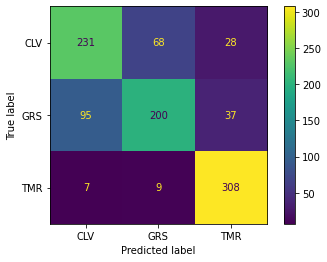

In [84]:
estimators = [ ("mnrk_itv1",minirocket_clf(start=0, end=172,verbose=False)),
           ("mrsqm_itv1",mrsqm_clf(nsax = 0, nsfa = 9,start=0, end=172,verbose=False)),
           ("freshprince_itv1",freshprince_clf(start=0, end=172,fc_pars="efficient",verbose=False)),
           ("RidgeCV_itv1",ridgecv_clf(start=0, end=172,verbose=False)),
             ("LDA_itv1",lda_clf(start=0, end=172,verbose=False)), 
            ("mnrk_itv2",minirocket_clf(start=205, end=306,verbose=False)),
           ("mrsqm_itv2",mrsqm_clf(nsax = 0, nsfa = 9,start=205, end=306,verbose=False)),
           ("freshprince_itv2",freshprince_clf(start=205, end=306,fc_pars="efficient",verbose=False)),
           ("RidgeCV_itv2",ridgecv_clf(start=205, end=306,verbose=False)),
             ("LDA_itv2",lda_clf(start=205, end=306,verbose=False)), 
          ]

weights = [2,2,2,2,2,1,1,1,1,1]

clf = VotingClassifier(estimators = estimators, weights=weights)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=clf.classes_)
disp.plot()
plt.show()

Accuracy: 0.6510681586978637


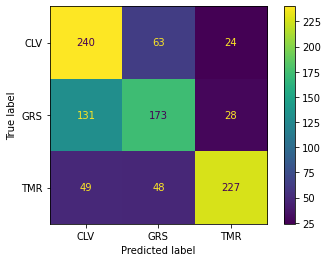

In [80]:
estimators = [ ("RidgeCV_itv1",ridgecv_clf(start=0, end=172,verbose=False)),
             ("LDA_itv1",lda_clf(start=0, end=172,verbose=False)),             
           ("RidgeCV_itv2",ridgecv_clf(start=205, end=306,verbose=False)),
             ("LDA_itv2",lda_clf(start=205, end=306,verbose=False)),          
          ]

#weights = [2,2,2,2,2,1,1,1,1,1]

clf = VotingClassifier(estimators = estimators)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=clf.classes_)
disp.plot()
plt.show()

Accuracy: 0.71617497456765


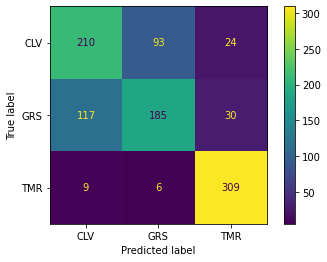

In [83]:
estimators = [ ("RidgeCV_itv1",ridgecv_clf(start=0, end=172,verbose=False)),
             ("LDA_itv1",lda_clf(start=0, end=172,verbose=False)),             
           ("RidgeCV_itv2",ridgecv_clf(start=205, end=306,verbose=False)),
             ("LDA_itv2",lda_clf(start=205, end=306,verbose=False)),          
          ]

weights = [2,2,1,1]

clf = VotingClassifier(estimators = estimators, weights = weights)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=clf.classes_)
disp.plot()
plt.show()